In [1]:
import boto3
import pickle
from dotenv import load_dotenv
import os
load_dotenv()

def load_model(bucket_name, model_path):
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )   
    response = s3_client.get_object(Bucket=bucket_name, Key=model_path)
    model = pickle.loads(response['Body'].read())
    return model


In [2]:
def load_test(bucket_name, dataset_path):
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    ) 
    response = s3_client.get_object(Bucket=bucket_name, Key=dataset_path)
    test_data = pickle.loads(response['Body'].read())
    return test_data


In [3]:
import numpy as np

def get_predictions(model, test_data):
    # Suponiendo que test_data es un DataFrame o una matriz que el modelo puede procesar
    predictions_score = model.predict_proba(test_data)[:, 1]  # Obtener la probabilidad para la clase positiva
    return predictions_score


In [4]:
from datetime import datetime

def save_predictions(predictions_score, bucket_name, save_path):
    date = datetime.now()
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )  
    predictions_data = {
        'date': date,
        'predictions_score': predictions_score.tolist()  # Convertir a lista para guardar
    }
    # Guardar como pickle
    pickle_data = pickle.dumps(predictions_data)
    s3_client.put_object(Bucket=bucket_name, Key=save_path, Body=pickle_data)


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def generate_roc(predictions_score, bucket_name, save_path,y_true):
    # Generar la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, predictions_score)  # y_true debe ser las etiquetas reales
    roc_auc = auc(fpr, tpr)

    # Graficar la curva ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    # Guardar la imagen en el bucket
    plt.savefig('/tmp/roc.png')
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )    
    with open('/tmp/roc.png', 'rb') as f:
        s3_client.put_object(Bucket=bucket_name, Key=save_path, Body=f)


In [6]:
from sklearn.metrics import classification_report
import pandas as pd

def save_metrics(predictions_score, y_true, bucket_name, save_path):
    # Generar las métricas
    pred_labels = (predictions_score >= 0.5).astype(int)  # Usando threshold de 0.5
    metrics = classification_report(y_true, pred_labels, output_dict=True)

    # Convertir a un DataFrame y guardar como pickle
    metrics_df = pd.DataFrame(metrics).transpose()
    metrics_pickle = pickle.dumps(metrics_df)
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    ) 
    s3_client.put_object(Bucket=bucket_name, Key=save_path, Body=metrics_pickle)


In [28]:
def load_threshold(bucket_name, threshold_path):
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )    
    response = s3_client.get_object(Bucket=bucket_name, Key=threshold_path)
    threshold = pickle.loads(response['Body'].read())
    return threshold

def generate_labels(predictions_score, threshold, bucket_name, save_path):
    # Si threshold es una tupla, extraer el primer valor
    thre= None
    if isinstance(threshold, tuple):
        print(f"Warning: El threshold es una tupla {threshold}, extrayendo el primer valor.")
        thre = threshold[0]

    # Si threshold es una lista o array, tomar solo el primer valor
    if isinstance(threshold, (list, np.ndarray)):
        if len(threshold) > 1:
            print(f"Warning: El threshold tiene múltiples valores {threshold}. Usando el primero: {threshold[0]}")
        thre = threshold[0]

    # Convertir a float
    thr = float(thre)

    # Asegurar que predictions_score es un array de NumPy
    predictions_score = np.array(predictions_score)

    # Generar etiquetas
    pred_labels = (predictions_score >= thr).astype(int)

    # Guardar en S3
    s3_client = boto3.client(
        's3',
        aws_access_key_id=os.getenv('NOTEBOOK_ACCESS_KEY'),
        aws_secret_access_key=os.getenv('NOTEBOOK_ACCESS_KEY_SECRET')
    )  
    labels_data = {'predictions_labels': pred_labels.tolist()}
    pickle_data = pickle.dumps(labels_data)
    s3_client.put_object(Bucket=bucket_name, Key=save_path, Body=pickle_data)

    print(f"Etiquetas generadas y guardadas en {save_path}")



Etiquetas generadas y guardadas en results/predictions_label.pkl


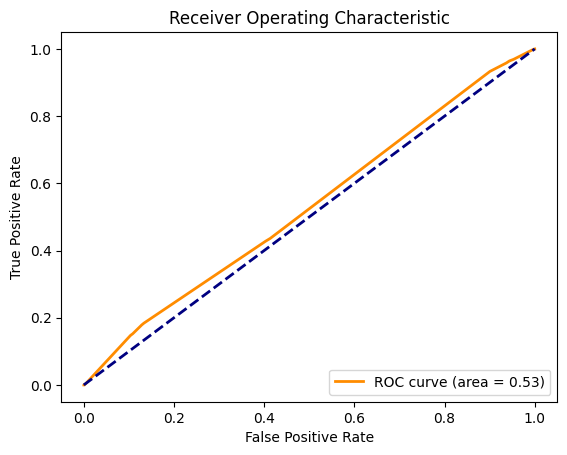

In [29]:
import pandas as pd

bucket_name="chicago-inspections-analytics"
model_path="selected-model/select_model.pkl"
dataset_path="dataset/test/test_dataset.pkl"
save_path_predictions="results/predictions_score.pkl"
save_path_ROC="results/roc.png"
save_path_predictions_table_metrics="results/metrics.pkl"
save_path_predictions_label="results/predictions_label.pkl"
path_treshold="best_model/threshold.pkl"
y_true_test_path="dataset/test/test_target.pkl"
y_true_test=load_model(bucket_name,y_true_test_path)
treshold=load_threshold(bucket_name,path_treshold)


y_true_numeric = [1 if label == 'pass' else 0 for label in y_true_test]
model=load_model(bucket_name, model_path)# Carga el modelo desde S3.
datosprueba=load_test(bucket_name, dataset_path)# Carga el conjunto de datos de prueba desde S3.
predictions_score=get_predictions(model, datosprueba)# Obtiene las predicciones del modelo en forma de scores (probabilidades).
save_predictions(predictions_score, bucket_name, save_path_predictions)# Guarda las predicciones junto con la fecha en S3.
generate_roc(predictions_score, bucket_name, save_path_ROC,y_true_numeric)# Genera la curva ROC y la guarda como imagen en S3.
save_metrics(predictions_score, y_true_numeric, bucket_name, save_path_predictions_table_metrics)# Genera las métricas y las guarda en S3.
generate_labels(predictions_score, treshold, bucket_name, save_path_predictions_label)# Genera las etiquetas con el threshold guardado y las guarda en S3. 